In [1]:
#Esta es una nueva versión en la que quiero dar más énfasis a los enlaces reales que hay en el dataset 
#para así garantixar la fidelidad. Cambiando sobre todo la generación de negativos,añadir pos_weight y ajustar 
#hiperparámetros de entrenamiento.

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import pickle
import torch
from torch_geometric.data import HeteroData
import torch.nn as nn
import networkx as nx
from tqdm import tqdm
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, to_hetero
import time
import matplotlib.pyplot as plt
import random
from torch_geometric.transforms import ToUndirected
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.transforms import RandomLinkSplit
from torch import Tensor
from sklearn.metrics import roc_auc_score, accuracy_score
import tqdm
import os
from sklearn.metrics import roc_auc_score, accuracy_score
import copy

## Crear nuestro Grafo

In [3]:
def create_drug_indication_graph(nodes_csv_path, edges_csv_path, embeddings_pkl_path, verbose=True):
    """
    Crea un grafo heterogéneo a partir de:
      - Un CSV de nodos que contiene columnas como "primaryDomainId", "type", "name", "description", etc.
      - Un CSV de edges que contiene, entre otros, las columnas "sourceDomainId", "targetDomainId" y una columna "relation"
        que puede tener valores como "DrugHasIndication", "DrugHasTarget", "ProteinEncodedByGene", "DisorderIsSubtypeOfDisorder", etc.
      - Un fichero .pkl con embeddings ya generados (por ejemplo, a partir de BERT) para cada nodo, mapeados mediante "primaryDomainId".
    
    El grafo resultante tendrá nodos agrupados por tipo (ej. "Drug", "Disorder", "Gene", "Protein") y edges etiquetados según la relación.
    Para nuestro objetivo, las relaciones de interés son las de tipo ("Drug", "DrugHasIndication", "Disorder").
    """
    data = HeteroData()
    
    # Cargar embeddings (suponemos que el .pkl tiene un diccionario con claves "Nodes Name" y "New Embedding")
    if verbose:
        print(f"[INFO] Cargando embeddings desde '{embeddings_pkl_path}'...")
    with open(embeddings_pkl_path, 'rb') as f:
        embeddings_dict = pickle.load(f)
    node_ids = embeddings_dict.get('Nodes Name', [])
    node_embeddings = embeddings_dict.get('New Embedding', [])
    embedding_map = {str(nid): np.array(emb) for nid, emb in zip(node_ids, node_embeddings)}
    
    # Cargar el CSV de nodos
    if verbose:
        print(f"[INFO] Cargando nodos desde '{nodes_csv_path}'...")
    nodes_df = pd.read_csv(nodes_csv_path, low_memory=False)
    
    # Crear un mapeo de nodo_id a tipo (usando la columna "type")
    id_to_type = {}
    # Inicializamos contenedores para cada tipo de nodo
    for ntype in ["Drug", "Disorder", "Gene", "Protein"]:
        data[ntype].x = []  # lista para acumular features
        data[ntype].id = []  # para almacenar el identificador original
    
    # Procesar cada nodo
    for _, row in nodes_df.iterrows():
        node_id = str(row['primaryDomainId'])
        node_type = row['type']
        # Solo procesamos los tipos de interés
        if node_type not in data.node_types:
            continue
        id_to_type[node_id] = node_type
        # Obtener la feature: si existe embedding para el nodo, lo usamos; si no, generamos un vector de ceros.
        if node_id in embedding_map:
            feat = embedding_map[node_id]
        else:
            # Supongamos dimensión 128 (ajusta según tu caso)
            feat = np.zeros(128)
        data[node_type].x.append(feat)
        data[node_type].id.append(node_id)
    
    # Convertir las listas de features a tensores para cada tipo de nodo
    for ntype in data.node_types:
        if len(data[ntype].x) > 0:
            features_array = np.array(data[ntype].x)
            data[ntype].x = torch.from_numpy(features_array).float()
            if hasattr(data[ntype], 'y') and isinstance(data[ntype].y, list):
                labels_array = np.array(data[ntype].y)
                data[ntype].y = torch.from_numpy(labels_array).long()
            if verbose:
                print(f"[INFO] {data[ntype].x.size(0)} nodos de tipo '{ntype}' con features de dimensión {data[ntype].x.size(1)}.")
        else:
            if verbose:
                print(f"[WARN] No se encontraron nodos de tipo '{ntype}'.")

    # Cargar el CSV de edges
    if verbose:
        print(f"[INFO] Cargando edges desde '{edges_csv_path}'...")
    edges_df = pd.read_csv(edges_csv_path, low_memory=False)
    
    # Procesar cada edge y agruparlos por tipo de relación
    # Se asume que el CSV de edges tiene columnas: "sourceDomainId", "targetDomainId" y "relation"
    edge_dict = {}  # clave: (src_type, relation, tgt_type) -> [lista de índices de origen, lista de índices de destino]
    for _, row in edges_df.iterrows():
        src_id = str(row['sourceDomainId'])
        tgt_id = str(row['targetDomainId'])
        relation = row['type']  # Ejemplos: "DrugHasIndication", "DrugHasTarget", etc.
        # Obtener tipos de nodo para el source y target
        src_type = id_to_type.get(src_id, None)
        tgt_type = id_to_type.get(tgt_id, None)
        if src_type is None or tgt_type is None:
            continue
        key = (src_type, relation, tgt_type)
        if key not in edge_dict:
            edge_dict[key] = [[], []]
        # Buscar el índice interno del nodo en su grupo
        try:
            src_idx = data[src_type].id.index(src_id)
            tgt_idx = data[tgt_type].id.index(tgt_id)
        except ValueError:
            continue
        edge_dict[key][0].append(src_idx)
        edge_dict[key][1].append(tgt_idx)
    
    # Agregar los edges al objeto HeteroData
    for (src_type, relation, tgt_type), (src_indices, tgt_indices) in edge_dict.items():
        edge_index = torch.tensor([src_indices, tgt_indices], dtype=torch.long)
        data[(src_type, relation, tgt_type)].edge_index = edge_index
        if verbose:
            print(f"[INFO] Agregados {edge_index.size(1)} edges para la relación ({src_type}, '{relation}', {tgt_type}).")
            
    #Añadir aristas inversas (reverse edges) para mejorar la propagación de información entre nodos y estabiliza el entrenamiento.        
    data = ToUndirected()(data)
    return data

#### Comprobaciones de que el grafo está bien hecho

In [4]:
def plot_graph_sample(data, max_nodes=100):
    """
    Visualiza un subgrafo del grafo heterogéneo, limitando la cantidad de nodos y edges para hacerlo legible.
    """
    G = nx.Graph()

    # Agregar nodos
    for node_type in data.node_types:
        num_nodes = data[node_type].x.shape[0]
        for i in range(min(num_nodes, max_nodes)):  # Limitar el número de nodos a mostrar
            G.add_node(f"{node_type}_{i}", label=node_type)

    # Agregar edges
    edge_colors = {}
    color_palette = ["r", "b", "g", "c", "m", "y"]
    
    for idx, edge_type in enumerate(data.edge_types):
        edge_index = data[edge_type].edge_index
        src_type, relation, tgt_type = edge_type
        color = color_palette[idx % len(color_palette)]  # Asignar un color diferente para cada tipo de relación
        edge_colors[relation] = color
        
        for i in range(min(edge_index.shape[1], max_nodes)):  # Limitar los edges a mostrar
            src = f"{src_type}_{edge_index[0, i].item()}"
            tgt = f"{tgt_type}_{edge_index[1, i].item()}"
            if src in G.nodes and tgt in G.nodes:
                G.add_edge(src, tgt, color=color)

    # Dibujar el grafo
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42)  # Layout para organizar los nodos
    edges = G.edges()
    edge_colors = [G[u][v]['color'] for u, v in edges]

    nx.draw(G, pos, with_labels=True, node_size=500, font_size=8, edge_color=edge_colors)
    plt.title("Visualización de un Subgrafo del Grafo de Drogas y Enfermedades")
    plt.show()


Creando el grafo...
[INFO] Cargando embeddings desde 'embeddings_mejorados_biobert.pkl'...
[INFO] Cargando nodos desde 'nodes.csv'...
[INFO] 7167 nodos de tipo 'Drug' con features de dimensión 768.
[INFO] 26015 nodos de tipo 'Disorder' con features de dimensión 768.
[INFO] 19394 nodos de tipo 'Gene' con features de dimensión 768.
[INFO] 30501 nodos de tipo 'Protein' con features de dimensión 768.
[INFO] Cargando edges desde 'edges.csv'...
[INFO] Agregados 48497 edges para la relación (Gene, 'GeneAssociatedWithDisorder', Disorder).
[INFO] Agregados 38881 edges para la relación (Disorder, 'DisorderIsSubtypeOfDisorder', Disorder).
[INFO] Agregados 30432 edges para la relación (Protein, 'ProteinEncodedByGene', Gene).
[INFO] Agregados 30088 edges para la relación (Drug, 'DrugHasTarget', Protein).
[INFO] Agregados 17728 edges para la relación (Drug, 'DrugHasIndication', Disorder).

 Resumen del grafo creado:
  - Drug: 7167 nodos
  - Disorder: 26015 nodos
  - Gene: 19394 nodos
  - Protein: 30

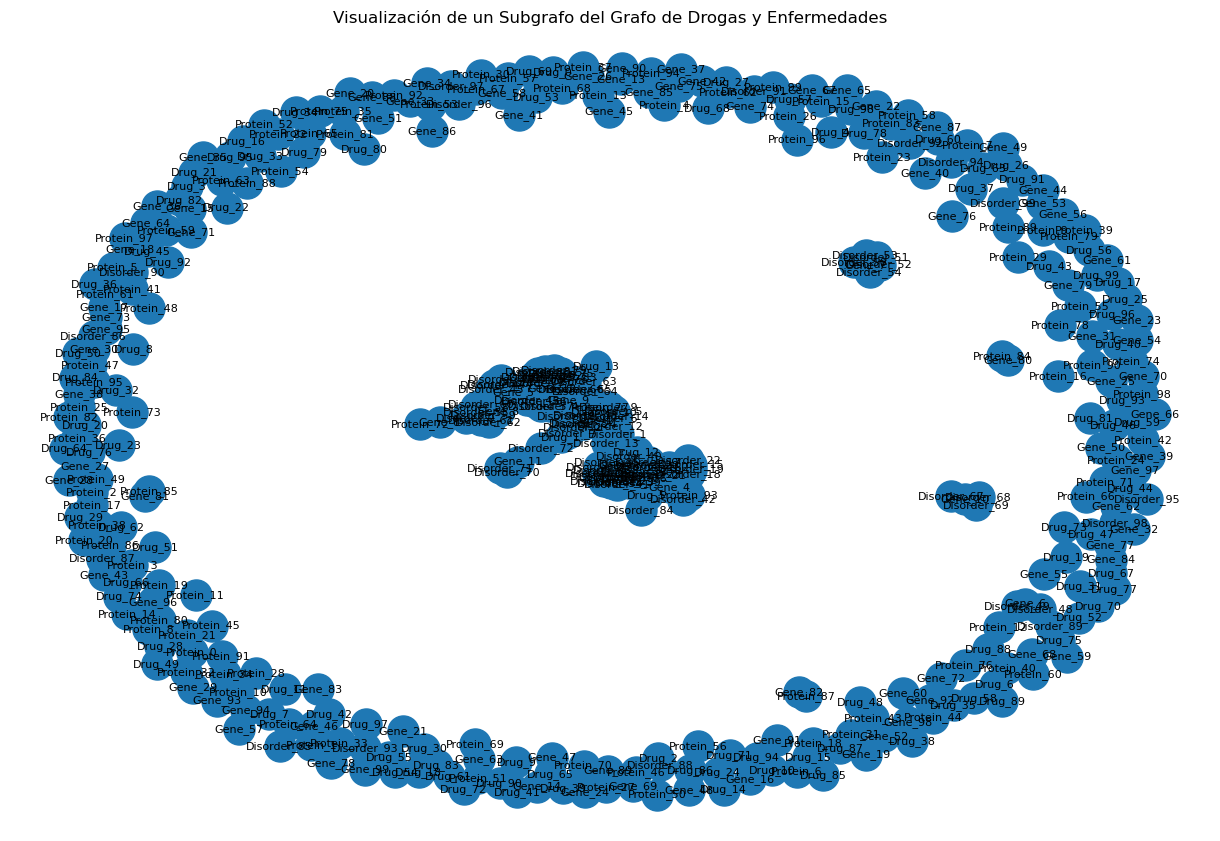

In [5]:
# Rutas a los archivos CSV y PKL
nodes_csv_path = "nodes.csv"
edges_csv_path = "edges.csv"
embeddings_pkl_path = "embeddings_mejorados_biobert.pkl"

# Crear el grafo
print("Creando el grafo...")
data = create_drug_indication_graph(nodes_csv_path, edges_csv_path, embeddings_pkl_path)

# Revisar nodos y edges
print("\n Resumen del grafo creado:")
for node_type in data.node_types:
    num_nodes = data[node_type].x.shape[0] if hasattr(data[node_type], "x") else 0
    print(f"  - {node_type}: {num_nodes} nodos")

for edge_type in data.edge_types:
    num_edges = data[edge_type].edge_index.shape[1]
    print(f"  - {edge_type}: {num_edges} edges")

# Visualizar el grafo
print("\n Generando visualización del grafo...")
plot_graph_sample(data)


In [6]:
#Como el anterior grafo no se ve bien, mejor probar con uno más pequeño
def plot_disorder_subgraph(data, disorder_index=None, max_connections=10):
    """
    Dibuja un subgrafo con un solo nodo 'Disorder' y sus conexiones con 'Drug' y otros nodos relacionados.
    
    Parámetros:
    - data: Grafo heterogéneo PyG.
    - disorder_index: Índice del disorder a visualizar (si es None, elige uno aleatorio).
    - max_connections: Máximo número de conexiones a mostrar.
    """
    G = nx.Graph()

    # Obtener lista de desórdenes
    disorder_nodes = data['Disorder'].id if hasattr(data['Disorder'], 'id') else []
    if not disorder_nodes:
        print(" No se encontraron nodos de tipo 'Disorder'.")
        return
    
    # Seleccionar un disorder aleatorio si no se especifica
    if disorder_index is None:
        disorder_index = random.choice(range(len(disorder_nodes)))
    
    disorder_node = f"Disorder_{disorder_index}"
    G.add_node(disorder_node, label="Disorder", color="red")

    # Buscar conexiones con otras entidades
    edge_types = [("Drug", "DrugHasIndication"), ("Gene", "GeneAssociatedWithDisorder")]
    
    connections = 0
    for target_type, relation in edge_types:
        if (target_type, relation, "Disorder") in data.edge_types:
            edge_index = data[(target_type, relation, "Disorder")].edge_index
            for i in range(edge_index.shape[1]):
                if edge_index[1, i].item() == disorder_index:
                    target_idx = edge_index[0, i].item()
                    target_node = f"{target_type}_{target_idx}"
                    G.add_node(target_node, label=target_type, color="blue" if target_type == "Drug" else "green")
                    G.add_edge(disorder_node, target_node, relation=relation)
                    connections += 1
                    if connections >= max_connections:
                        break
    
    if G.number_of_edges() == 0:
        print(f" El nodo 'Disorder_{disorder_index}' no tiene conexiones relevantes.")
        return

    # Dibujar el grafo
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=42)  
    colors = [G.nodes[n]["color"] for n in G.nodes]
    
    nx.draw(G, pos, with_labels=True, node_color=colors, node_size=1000, font_size=8, edge_color="gray")
    plt.title(f"Subgrafo de 'Disorder_{disorder_index}' y sus conexiones")
    plt.show()


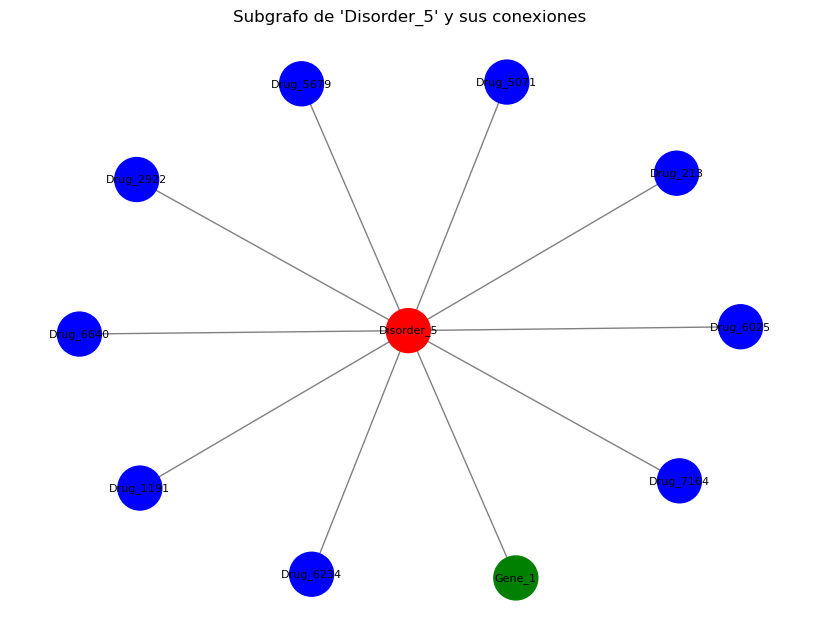

In [7]:
plot_disorder_subgraph(data, disorder_index=5)  # Si se quiere otra disorder se cambia el número


In [5]:
print(data)

HeteroData(
  Drug={
    x=[7167, 768],
    id=[7167],
  },
  Disorder={
    x=[26015, 768],
    id=[26015],
  },
  Gene={
    x=[19394, 768],
    id=[19394],
  },
  Protein={
    x=[30501, 768],
    id=[30501],
  },
  (Gene, GeneAssociatedWithDisorder, Disorder)={ edge_index=[2, 48497] },
  (Disorder, DisorderIsSubtypeOfDisorder, Disorder)={ edge_index=[2, 77762] },
  (Protein, ProteinEncodedByGene, Gene)={ edge_index=[2, 30432] },
  (Drug, DrugHasTarget, Protein)={ edge_index=[2, 30088] },
  (Drug, DrugHasIndication, Disorder)={ edge_index=[2, 17728] },
  (Disorder, rev_GeneAssociatedWithDisorder, Gene)={ edge_index=[2, 48497] },
  (Gene, rev_ProteinEncodedByGene, Protein)={ edge_index=[2, 30432] },
  (Protein, rev_DrugHasTarget, Drug)={ edge_index=[2, 30088] },
  (Disorder, rev_DrugHasIndication, Drug)={ edge_index=[2, 17728] }
)


## Pasos previos a entrenar el modelo 

### Dividir nuestro Heterodata para separarlo en train, val y test

In [6]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
import copy

# 1. Cargar el CSV limpio
df_edges = pd.read_csv("drug_has_indication_edges.csv").dropna()

# 2. Crear positivos
positive_edges = list(df_edges.itertuples(index=False, name=None))
drug_ids = df_edges["sourceDomainId"].unique().tolist()
disorder_ids = df_edges["targetDomainId"].unique().tolist()

# 3. Crear negativos
positive_set = set(positive_edges)
negatives = set()
while len(negatives) < len(positive_edges):
    d = random.choice(drug_ids)
    dis = random.choice(disorder_ids)
    if (d, dis) not in positive_set:
        negatives.add((d, dis))

# 4. Juntar todo y añadir etiquetas
all_edges = positive_edges + list(negatives)
all_labels = [1] * len(positive_edges) + [0] * len(negatives)
df_all = pd.DataFrame(all_edges, columns=["drug", "disorder"])
df_all["label"] = all_labels

# 5. Dividir en train, val, test
train_val, test = train_test_split(df_all, test_size=0.2, stratify=df_all["label"], random_state=42)
train, val = train_test_split(train_val, test_size=0.125, stratify=train_val["label"], random_state=42)

# 6. Crear mapeos de ID a índice en el grafo
drug_id_to_idx = {id_: i for i, id_ in enumerate(data["Drug"].id)}
disorder_id_to_idx = {id_: i for i, id_ in enumerate(data["Disorder"].id)}

# 7. Convertir dataframe a tensores de edge_label y edge_label_index
def df_to_edge_index_and_label(df, drug_map, disorder_map):
    edge_index = []
    labels = []
    for row in df.itertuples(index=False):
        d_id, dis_id, label = row
        if d_id in drug_map and dis_id in disorder_map:
            edge_index.append([drug_map[d_id], disorder_map[dis_id]])
            labels.append(label)
    edge_index = torch.tensor(edge_index).t().contiguous()
    edge_label = torch.tensor(labels, dtype=torch.float)
    return edge_index, edge_label

train_edge_index, train_edge_label = df_to_edge_index_and_label(train, drug_id_to_idx, disorder_id_to_idx)
val_edge_index, val_edge_label = df_to_edge_index_and_label(val, drug_id_to_idx, disorder_id_to_idx)
test_edge_index, test_edge_label = df_to_edge_index_and_label(test, drug_id_to_idx, disorder_id_to_idx)

# 8. Clonar el grafo original y añadir la información de enlaces
train_data = copy.deepcopy(data)
val_data = copy.deepcopy(data)
test_data = copy.deepcopy(data)

train_data["Drug", "DrugHasIndication", "Disorder"].edge_label_index = train_edge_index
train_data["Drug", "DrugHasIndication", "Disorder"].edge_label = train_edge_label

val_data["Drug", "DrugHasIndication", "Disorder"].edge_label_index = val_edge_index
val_data["Drug", "DrugHasIndication", "Disorder"].edge_label = val_edge_label

test_data["Drug", "DrugHasIndication", "Disorder"].edge_label_index = test_edge_index
test_data["Drug", "DrugHasIndication", "Disorder"].edge_label = test_edge_label

# 9. Comprobaciones básicas
print(f"Train: {len(train_edge_label)} enlaces ({(train_edge_label==1).sum()} positivos)")
print(f"Val:   {len(val_edge_label)} enlaces ({(val_edge_label==1).sum()} positivos)")
print(f"Test:  {len(test_edge_label)} enlaces ({(test_edge_label==1).sum()} positivos)")

print("Ejemplo train edge_label_index:", train_edge_index[:, :5])
print("Ejemplo train edge_label:", train_edge_label[:5])


Train: 24818 enlaces (12409 positivos)
Val:   3546 enlaces (1773 positivos)
Test:  7092 enlaces (3546 positivos)
Ejemplo train edge_label_index: tensor([[6640, 6330, 4968, 5680, 5011],
        [ 517, 8188,  638, 7795, 7801]])
Ejemplo train edge_label: tensor([1., 0., 0., 0., 0.])


## Creación de nuestro modelo GraphSAGE

## Training

In [7]:
from train_gat import Model, train_loop_bce

model = Model(hidden_channels=128, dropout=0.3)
model = train_loop_bce(model, train_data, val_data, device="cpu")



C:\Users\gema\anaconda3\envs\TFM_NUEVO\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
C:\Users\gema\anaconda3\envs\TFM_NUEVO\lib\site-packages\torch_geometric\nn\fx.py:132: UserWarning: Found function 'dropout' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword "
C:\Users\gema\anaconda3\envs\TFM_NUEVO\lib\site-packages\torch_geometric\nn\fx.py:132: UserWarning: Found function 'dropout_1' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found functi

Epoch 01 | TrainLoss=0.7022 | AUC=0.4243 | ValLoss=0.6937 | ValAUC=0.4382 | MRR_local=0.8734 | NDCG@50=0.9090
Epoch 02 | TrainLoss=0.6964 | AUC=0.4783 | ValLoss=0.6936 | ValAUC=0.4462 | MRR_local=0.8890 | NDCG@50=0.9187
Epoch 03 | TrainLoss=0.6936 | AUC=0.5127 | ValLoss=0.6934 | ValAUC=0.4823 | MRR_local=0.8726 | NDCG@50=0.9065
Epoch 04 | TrainLoss=0.6896 | AUC=0.5694 | ValLoss=0.6934 | ValAUC=0.4820 | MRR_local=0.8935 | NDCG@50=0.9228
Epoch 05 | TrainLoss=0.6850 | AUC=0.6208 | ValLoss=0.6929 | ValAUC=0.5554 | MRR_local=0.8817 | NDCG@50=0.9136
Epoch 06 | TrainLoss=0.6812 | AUC=0.6523 | ValLoss=0.6929 | ValAUC=0.5447 | MRR_local=0.8884 | NDCG@50=0.9184
Epoch 07 | TrainLoss=0.6811 | AUC=0.6506 | ValLoss=0.6925 | ValAUC=0.5682 | MRR_local=0.8947 | NDCG@50=0.9244
Epoch 08 | TrainLoss=0.6750 | AUC=0.6943 | ValLoss=0.6927 | ValAUC=0.5534 | MRR_local=0.9034 | NDCG@50=0.9286
Epoch 09 | TrainLoss=0.6749 | AUC=0.6920 | ValLoss=0.6924 | ValAUC=0.5743 | MRR_local=0.9036 | NDCG@50=0.9294
Epoch 10 |

## Evaluación

### Evaluación con métricas usando test_data

In [12]:
import torch
from train_gat import Model, evaluate_bce
from torch_geometric.data import HeteroData

# 1. Crear el modelo con las mismas configuraciones que usaste en el entrenamiento
hidden_channels = 128  # Esto debe coincidir con lo que usaste en el entrenamiento
model = Model(hidden_channels=hidden_channels, dropout=0.3)

# 2. Mover el modelo a dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 3. ⚠️ IMPORTANTE: pasa primero un forward con `train_data` para construir la arquitectura heterogénea
_ = model(train_data)  # Llamada para preparar el modelo

# 4. Cargar los pesos guardados
model.load_state_dict(torch.load("gnn_model_gat_bce.pth", map_location=device), strict=False)

# 5. Evaluar el modelo en el conjunto de prueba
test_loss, test_auc, test_acc, test_recall = evaluate_bce(
    model, test_data, device, calc_recall_topk=100
)

# 6. Mostrar los resultados del conjunto de prueba
print(f"Test Loss: {test_loss:.4f} | Test AUC: {test_auc:.4f} | Test Accuracy: {test_acc:.4f} | Test Recall@100: {test_recall:.4f}")



C:\Users\gema\anaconda3\envs\TFM_NUEVO\lib\site-packages\torch_geometric\nn\fx.py:132: UserWarning: Found function 'dropout' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword "
C:\Users\gema\anaconda3\envs\TFM_NUEVO\lib\site-packages\torch_geometric\nn\fx.py:132: UserWarning: Found function 'dropout_1' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword "


Test Loss: 0.5392 | Test AUC: 0.8205 | Test Accuracy: 0.7407 | Test Recall@100: 0.0259


In [ ]:
## evaluar en test_data y luego calculas métricas con ese pred
model.eval()
pred = model(test_data)



In [13]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score
from train_gat import (
    evaluate_local_ranking_metrics,
    compute_recall_at_k
)

@torch.no_grad()
def evaluate_test_metrics(model, test_data, device='cpu', k_recall=100, ndcg_k=50):
    model.eval()
    test_data = test_data.to(device)

    pred = model(test_data)  # logits
    probs = torch.sigmoid(pred).cpu().numpy()
    labels = test_data["Drug", "DrugHasIndication", "Disorder"].edge_label.cpu().numpy()

    # AUC y Accuracy
    auc = roc_auc_score(labels, probs) if len(np.unique(labels)) > 1 else 0.0
    acc = accuracy_score(labels, (probs >= 0.5))

    # Recall@k
    recall_k = compute_recall_at_k(probs, labels, k=k_recall)

    # Ranking local
    mrr_local, ndcg_local = evaluate_local_ranking_metrics(
        model, test_data, device=device, ndcg_k=ndcg_k
    )

    print("📊 Evaluación en Test:")
    print(f"  - AUC           : {auc:.4f}")
    print(f"  - Accuracy      : {acc:.4f}")
    print(f"  - Recall@{k_recall:>2}    : {recall_k:.4f}")
    print(f"  - MRR Local     : {mrr_local:.4f}")
    print(f"  - NDCG@{ndcg_k}       : {ndcg_local:.4f}")

    return {
        "AUC": auc,
        "Accuracy": acc,
        f"Recall@{k_recall}": recall_k,
        "MRR_local": mrr_local,
        f"NDCG@{ndcg_k}": ndcg_local
    }

# Ejecutar evaluación:
metrics = evaluate_test_metrics(model, test_data, device=device)


📊 Evaluación en Test:
  - AUC           : 0.8235
  - Accuracy      : 0.7503
  - Recall@100    : 0.0268
  - MRR Local     : 0.8999
  - NDCG@50       : 0.9231


### Evaluación de la relación drug --> disorder

In [ ]:
"""
Breve explicación sobre Link Prediction y por qué puede que el modelo
no muestre primero un enlace real del dataset:

En problemas de Link Prediction, el modelo (en este caso, una GNN) aprende
patrones de las aristas existentes (DrugHasIndication, etc.) para predecir
la probabilidad de enlaces nuevos o no observados. Al inferir (por ejemplo,
al pedir "top 5 disorders" para una cierta drug), el modelo rankea todas
las posibles conexiones según la probabilidad aprendida.

Es posible que un enlace 'real' (por ejemplo, (drug=6881, disorder=42))
aparezca lejos en el ranking (en el puesto 1817 en mi caso, con prob alta igualmente) incluso si
sí existe en el dataset. Esto sucede porque:

1) El modelo no está obligado a reproducir fielmente los enlaces originales
   en el top. Su objetivo es generalizar patrones aprendidos; puede “preferir”
   otras conexiones con puntuaciones aún mayores.
2) Durante el entrenamiento, la evidencia de ese enlace pudo no haber sido
   lo bastante fuerte (o quedó diluida) frente a otras asociaciones con
   características similares, resultando en una menor probabilidad final.
3) Link Prediction produce una ordenación estadística de la probabilidad
   de cada enlace, pero no garantiza que los enlaces “reales” queden siempre
   en los primeros lugares.

En resumen, que un enlace real del dataset no aparezca en el top N no es
un error: el modelo simplemente aprendió que, según sus patrones, otras
conexiones son más probables. Aun así, sigue asignándole una cierta
probabilidad (>0.8, por ejemplo), y confirma que “conoce” ese enlace, 
aunque no lo destaque en los primeros puestos.

Además es típico que un modelo de link prediction pueda sugerir fármacos sin respaldo clínico para esa enfermedad concreta, 
dado que se basa en patrones estadísticos de tu base de datos y no en evidencia médica directa.

el resultado del modelo debe tomarse solo como una hipótesis estadística, no como recomendación terapéutica.
"""


In [15]:
import torch
import pandas as pd
from train_gnn_model import Model

# -----------------------------------------
# 1. Cargar nodos para mapear ID → nombre
# -----------------------------------------
df_nodes = pd.read_csv("nodes.csv", low_memory=False)
id_to_name = df_nodes.set_index("primaryDomainId")["displayName"].to_dict()

# -----------------------------------------
# 2. Preparar modelo y cargar pesos entrenados
# -----------------------------------------
model = Model(hidden_channels=768, dropout=0.3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# ⚠️ Inicializa `hetero_gnn` con test_data (que tiene edge_label_index)
with torch.no_grad():
    _ = model(test_data.to(device))  # No genera error

# Ahora ya puedes cargar los pesos
model.load_state_dict(torch.load("gnn_model_gat_bce.pth", map_location=device))
model.eval()

# -----------------------------------------
# 3. Obtener embeddings de todos los nodos
# -----------------------------------------
@torch.no_grad()
def get_node_embeddings(model, data):
    model.eval()
    x_dict = {
        "Drug": model.drug_lin(data["Drug"].x.to(device)),
        "Disorder": model.disorder_lin(data["Disorder"].x.to(device)),
        "Protein": model.protein_lin(data["Protein"].x.to(device)),
        "Gene": model.gene_lin(data["Gene"].x.to(device)),
    }
    return model.hetero_gnn(x_dict, data.edge_index_dict)

embeddings = get_node_embeddings(model, data)

# -----------------------------------------
# 4. Función para predicción top-k
# -----------------------------------------
def predict_top_k_links(embeddings, source_type, target_type, input_id, k=5):
    source_ids = data[source_type].id  # ⚠️ Ya es una lista
    target_ids = data[target_type].id

    if input_id not in source_ids:
        raise ValueError(f"ID '{input_id}' no encontrado en los nodos de tipo '{source_type}'.")

    source_idx = source_ids.index(input_id)
    source_emb = embeddings[source_type][source_idx]

    all_target_embs = embeddings[target_type]
    scores = torch.nn.functional.cosine_similarity(
        source_emb.unsqueeze(0), all_target_embs
    )

    top_k_idx = torch.topk(scores, k=k).indices.tolist()
    top_k_ids = [target_ids[i] for i in top_k_idx]
    top_k_scores = [scores[i].item() for i in top_k_idx]

    return [(id_to_name.get(tid, tid), score) for tid, score in zip(top_k_ids, top_k_scores)]

# -----------------------------------------
# 5. Ejemplo: Predecir enfermedades asociadas a un fármaco
# -----------------------------------------
input_drug_id = "drugbank.DB00001"
k = 5
print(f"\n🔍 Fármaco: {id_to_name.get(input_drug_id, input_drug_id)}")
print("Enfermedades predichas:")

for name, score in predict_top_k_links(embeddings, "Drug", "Disorder", input_drug_id, k=k):
    print(f"  - {name} (score={score})")

# -----------------------------------------
# 6. Ejemplo inverso: Predecir medicamentos para una enfermedad
# -----------------------------------------
input_disorder_id = "mondo.0004975"
k = 5
print(f"\n🔍 Enfermedad: {id_to_name.get(input_disorder_id, input_disorder_id)}")
print("Fármacos predichos:")

for name, score in predict_top_k_links(embeddings, "Disorder", "Drug", input_disorder_id, k=k):
    print(f"  - {name} (score={score})")

C:\Users\gema\anaconda3\envs\TFM_NUEVO\lib\site-packages\torch_geometric\nn\fx.py:132: UserWarning: Found function 'dropout' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword "
C:\Users\gema\anaconda3\envs\TFM_NUEVO\lib\site-packages\torch_geometric\nn\fx.py:132: UserWarning: Found function 'dropout_1' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword "


RuntimeError: Error(s) in loading state_dict for Model:
	Missing key(s) in state_dict: "gnn.convs.0.lin_l.weight", "gnn.convs.0.lin_l.bias", "gnn.convs.0.lin_r.weight", "gnn.convs.1.lin_l.weight", "gnn.convs.1.lin_l.bias", "gnn.convs.1.lin_r.weight", "gnn.convs.2.lin_l.weight", "gnn.convs.2.lin_l.bias", "gnn.convs.2.lin_r.weight", "hetero_gnn.convs.0.Gene__GeneAssociatedWithDisorder__Disorder.lin_l.weight", "hetero_gnn.convs.0.Gene__GeneAssociatedWithDisorder__Disorder.lin_l.bias", "hetero_gnn.convs.0.Gene__GeneAssociatedWithDisorder__Disorder.lin_r.weight", "hetero_gnn.convs.0.Disorder__DisorderIsSubtypeOfDisorder__Disorder.lin_l.weight", "hetero_gnn.convs.0.Disorder__DisorderIsSubtypeOfDisorder__Disorder.lin_l.bias", "hetero_gnn.convs.0.Disorder__DisorderIsSubtypeOfDisorder__Disorder.lin_r.weight", "hetero_gnn.convs.0.Protein__ProteinEncodedByGene__Gene.lin_l.weight", "hetero_gnn.convs.0.Protein__ProteinEncodedByGene__Gene.lin_l.bias", "hetero_gnn.convs.0.Protein__ProteinEncodedByGene__Gene.lin_r.weight", "hetero_gnn.convs.0.Drug__DrugHasTarget__Protein.lin_l.weight", "hetero_gnn.convs.0.Drug__DrugHasTarget__Protein.lin_l.bias", "hetero_gnn.convs.0.Drug__DrugHasTarget__Protein.lin_r.weight", "hetero_gnn.convs.0.Drug__DrugHasIndication__Disorder.lin_l.weight", "hetero_gnn.convs.0.Drug__DrugHasIndication__Disorder.lin_l.bias", "hetero_gnn.convs.0.Drug__DrugHasIndication__Disorder.lin_r.weight", "hetero_gnn.convs.0.Disorder__rev_GeneAssociatedWithDisorder__Gene.lin_l.weight", "hetero_gnn.convs.0.Disorder__rev_GeneAssociatedWithDisorder__Gene.lin_l.bias", "hetero_gnn.convs.0.Disorder__rev_GeneAssociatedWithDisorder__Gene.lin_r.weight", "hetero_gnn.convs.0.Gene__rev_ProteinEncodedByGene__Protein.lin_l.weight", "hetero_gnn.convs.0.Gene__rev_ProteinEncodedByGene__Protein.lin_l.bias", "hetero_gnn.convs.0.Gene__rev_ProteinEncodedByGene__Protein.lin_r.weight", "hetero_gnn.convs.0.Protein__rev_DrugHasTarget__Drug.lin_l.weight", "hetero_gnn.convs.0.Protein__rev_DrugHasTarget__Drug.lin_l.bias", "hetero_gnn.convs.0.Protein__rev_DrugHasTarget__Drug.lin_r.weight", "hetero_gnn.convs.0.Disorder__rev_DrugHasIndication__Drug.lin_l.weight", "hetero_gnn.convs.0.Disorder__rev_DrugHasIndication__Drug.lin_l.bias", "hetero_gnn.convs.0.Disorder__rev_DrugHasIndication__Drug.lin_r.weight", "hetero_gnn.convs.1.Gene__GeneAssociatedWithDisorder__Disorder.lin_l.weight", "hetero_gnn.convs.1.Gene__GeneAssociatedWithDisorder__Disorder.lin_l.bias", "hetero_gnn.convs.1.Gene__GeneAssociatedWithDisorder__Disorder.lin_r.weight", "hetero_gnn.convs.1.Disorder__DisorderIsSubtypeOfDisorder__Disorder.lin_l.weight", "hetero_gnn.convs.1.Disorder__DisorderIsSubtypeOfDisorder__Disorder.lin_l.bias", "hetero_gnn.convs.1.Disorder__DisorderIsSubtypeOfDisorder__Disorder.lin_r.weight", "hetero_gnn.convs.1.Protein__ProteinEncodedByGene__Gene.lin_l.weight", "hetero_gnn.convs.1.Protein__ProteinEncodedByGene__Gene.lin_l.bias", "hetero_gnn.convs.1.Protein__ProteinEncodedByGene__Gene.lin_r.weight", "hetero_gnn.convs.1.Drug__DrugHasTarget__Protein.lin_l.weight", "hetero_gnn.convs.1.Drug__DrugHasTarget__Protein.lin_l.bias", "hetero_gnn.convs.1.Drug__DrugHasTarget__Protein.lin_r.weight", "hetero_gnn.convs.1.Drug__DrugHasIndication__Disorder.lin_l.weight", "hetero_gnn.convs.1.Drug__DrugHasIndication__Disorder.lin_l.bias", "hetero_gnn.convs.1.Drug__DrugHasIndication__Disorder.lin_r.weight", "hetero_gnn.convs.1.Disorder__rev_GeneAssociatedWithDisorder__Gene.lin_l.weight", "hetero_gnn.convs.1.Disorder__rev_GeneAssociatedWithDisorder__Gene.lin_l.bias", "hetero_gnn.convs.1.Disorder__rev_GeneAssociatedWithDisorder__Gene.lin_r.weight", "hetero_gnn.convs.1.Gene__rev_ProteinEncodedByGene__Protein.lin_l.weight", "hetero_gnn.convs.1.Gene__rev_ProteinEncodedByGene__Protein.lin_l.bias", "hetero_gnn.convs.1.Gene__rev_ProteinEncodedByGene__Protein.lin_r.weight", "hetero_gnn.convs.1.Protein__rev_DrugHasTarget__Drug.lin_l.weight", "hetero_gnn.convs.1.Protein__rev_DrugHasTarget__Drug.lin_l.bias", "hetero_gnn.convs.1.Protein__rev_DrugHasTarget__Drug.lin_r.weight", "hetero_gnn.convs.1.Disorder__rev_DrugHasIndication__Drug.lin_l.weight", "hetero_gnn.convs.1.Disorder__rev_DrugHasIndication__Drug.lin_l.bias", "hetero_gnn.convs.1.Disorder__rev_DrugHasIndication__Drug.lin_r.weight", "hetero_gnn.convs.2.Gene__GeneAssociatedWithDisorder__Disorder.lin_l.weight", "hetero_gnn.convs.2.Gene__GeneAssociatedWithDisorder__Disorder.lin_l.bias", "hetero_gnn.convs.2.Gene__GeneAssociatedWithDisorder__Disorder.lin_r.weight", "hetero_gnn.convs.2.Disorder__DisorderIsSubtypeOfDisorder__Disorder.lin_l.weight", "hetero_gnn.convs.2.Disorder__DisorderIsSubtypeOfDisorder__Disorder.lin_l.bias", "hetero_gnn.convs.2.Disorder__DisorderIsSubtypeOfDisorder__Disorder.lin_r.weight", "hetero_gnn.convs.2.Protein__ProteinEncodedByGene__Gene.lin_l.weight", "hetero_gnn.convs.2.Protein__ProteinEncodedByGene__Gene.lin_l.bias", "hetero_gnn.convs.2.Protein__ProteinEncodedByGene__Gene.lin_r.weight", "hetero_gnn.convs.2.Drug__DrugHasTarget__Protein.lin_l.weight", "hetero_gnn.convs.2.Drug__DrugHasTarget__Protein.lin_l.bias", "hetero_gnn.convs.2.Drug__DrugHasTarget__Protein.lin_r.weight", "hetero_gnn.convs.2.Drug__DrugHasIndication__Disorder.lin_l.weight", "hetero_gnn.convs.2.Drug__DrugHasIndication__Disorder.lin_l.bias", "hetero_gnn.convs.2.Drug__DrugHasIndication__Disorder.lin_r.weight", "hetero_gnn.convs.2.Disorder__rev_GeneAssociatedWithDisorder__Gene.lin_l.weight", "hetero_gnn.convs.2.Disorder__rev_GeneAssociatedWithDisorder__Gene.lin_l.bias", "hetero_gnn.convs.2.Disorder__rev_GeneAssociatedWithDisorder__Gene.lin_r.weight", "hetero_gnn.convs.2.Gene__rev_ProteinEncodedByGene__Protein.lin_l.weight", "hetero_gnn.convs.2.Gene__rev_ProteinEncodedByGene__Protein.lin_l.bias", "hetero_gnn.convs.2.Gene__rev_ProteinEncodedByGene__Protein.lin_r.weight", "hetero_gnn.convs.2.Protein__rev_DrugHasTarget__Drug.lin_l.weight", "hetero_gnn.convs.2.Protein__rev_DrugHasTarget__Drug.lin_l.bias", "hetero_gnn.convs.2.Protein__rev_DrugHasTarget__Drug.lin_r.weight", "hetero_gnn.convs.2.Disorder__rev_DrugHasIndication__Drug.lin_l.weight", "hetero_gnn.convs.2.Disorder__rev_DrugHasIndication__Drug.lin_l.bias", "hetero_gnn.convs.2.Disorder__rev_DrugHasIndication__Drug.lin_r.weight". 
	Unexpected key(s) in state_dict: "gnn.convs.0.att_src", "gnn.convs.0.att_dst", "gnn.convs.0.bias", "gnn.convs.0.lin.weight", "gnn.convs.1.att_src", "gnn.convs.1.att_dst", "gnn.convs.1.bias", "gnn.convs.1.lin.weight", "gnn.convs.2.att_src", "gnn.convs.2.att_dst", "gnn.convs.2.bias", "gnn.convs.2.lin.weight", "hetero_gnn.convs.0.Gene__GeneAssociatedWithDisorder__Disorder.att_src", "hetero_gnn.convs.0.Gene__GeneAssociatedWithDisorder__Disorder.att_dst", "hetero_gnn.convs.0.Gene__GeneAssociatedWithDisorder__Disorder.bias", "hetero_gnn.convs.0.Gene__GeneAssociatedWithDisorder__Disorder.lin.weight", "hetero_gnn.convs.0.Disorder__DisorderIsSubtypeOfDisorder__Disorder.att_src", "hetero_gnn.convs.0.Disorder__DisorderIsSubtypeOfDisorder__Disorder.att_dst", "hetero_gnn.convs.0.Disorder__DisorderIsSubtypeOfDisorder__Disorder.bias", "hetero_gnn.convs.0.Disorder__DisorderIsSubtypeOfDisorder__Disorder.lin.weight", "hetero_gnn.convs.0.Protein__ProteinEncodedByGene__Gene.att_src", "hetero_gnn.convs.0.Protein__ProteinEncodedByGene__Gene.att_dst", "hetero_gnn.convs.0.Protein__ProteinEncodedByGene__Gene.bias", "hetero_gnn.convs.0.Protein__ProteinEncodedByGene__Gene.lin.weight", "hetero_gnn.convs.0.Drug__DrugHasTarget__Protein.att_src", "hetero_gnn.convs.0.Drug__DrugHasTarget__Protein.att_dst", "hetero_gnn.convs.0.Drug__DrugHasTarget__Protein.bias", "hetero_gnn.convs.0.Drug__DrugHasTarget__Protein.lin.weight", "hetero_gnn.convs.0.Drug__DrugHasIndication__Disorder.att_src", "hetero_gnn.convs.0.Drug__DrugHasIndication__Disorder.att_dst", "hetero_gnn.convs.0.Drug__DrugHasIndication__Disorder.bias", "hetero_gnn.convs.0.Drug__DrugHasIndication__Disorder.lin.weight", "hetero_gnn.convs.0.Disorder__rev_GeneAssociatedWithDisorder__Gene.att_src", "hetero_gnn.convs.0.Disorder__rev_GeneAssociatedWithDisorder__Gene.att_dst", "hetero_gnn.convs.0.Disorder__rev_GeneAssociatedWithDisorder__Gene.bias", "hetero_gnn.convs.0.Disorder__rev_GeneAssociatedWithDisorder__Gene.lin.weight", "hetero_gnn.convs.0.Gene__rev_ProteinEncodedByGene__Protein.att_src", "hetero_gnn.convs.0.Gene__rev_ProteinEncodedByGene__Protein.att_dst", "hetero_gnn.convs.0.Gene__rev_ProteinEncodedByGene__Protein.bias", "hetero_gnn.convs.0.Gene__rev_ProteinEncodedByGene__Protein.lin.weight", "hetero_gnn.convs.0.Protein__rev_DrugHasTarget__Drug.att_src", "hetero_gnn.convs.0.Protein__rev_DrugHasTarget__Drug.att_dst", "hetero_gnn.convs.0.Protein__rev_DrugHasTarget__Drug.bias", "hetero_gnn.convs.0.Protein__rev_DrugHasTarget__Drug.lin.weight", "hetero_gnn.convs.0.Disorder__rev_DrugHasIndication__Drug.att_src", "hetero_gnn.convs.0.Disorder__rev_DrugHasIndication__Drug.att_dst", "hetero_gnn.convs.0.Disorder__rev_DrugHasIndication__Drug.bias", "hetero_gnn.convs.0.Disorder__rev_DrugHasIndication__Drug.lin.weight", "hetero_gnn.convs.1.Gene__GeneAssociatedWithDisorder__Disorder.att_src", "hetero_gnn.convs.1.Gene__GeneAssociatedWithDisorder__Disorder.att_dst", "hetero_gnn.convs.1.Gene__GeneAssociatedWithDisorder__Disorder.bias", "hetero_gnn.convs.1.Gene__GeneAssociatedWithDisorder__Disorder.lin.weight", "hetero_gnn.convs.1.Disorder__DisorderIsSubtypeOfDisorder__Disorder.att_src", "hetero_gnn.convs.1.Disorder__DisorderIsSubtypeOfDisorder__Disorder.att_dst", "hetero_gnn.convs.1.Disorder__DisorderIsSubtypeOfDisorder__Disorder.bias", "hetero_gnn.convs.1.Disorder__DisorderIsSubtypeOfDisorder__Disorder.lin.weight", "hetero_gnn.convs.1.Protein__ProteinEncodedByGene__Gene.att_src", "hetero_gnn.convs.1.Protein__ProteinEncodedByGene__Gene.att_dst", "hetero_gnn.convs.1.Protein__ProteinEncodedByGene__Gene.bias", "hetero_gnn.convs.1.Protein__ProteinEncodedByGene__Gene.lin.weight", "hetero_gnn.convs.1.Drug__DrugHasTarget__Protein.att_src", "hetero_gnn.convs.1.Drug__DrugHasTarget__Protein.att_dst", "hetero_gnn.convs.1.Drug__DrugHasTarget__Protein.bias", "hetero_gnn.convs.1.Drug__DrugHasTarget__Protein.lin.weight", "hetero_gnn.convs.1.Drug__DrugHasIndication__Disorder.att_src", "hetero_gnn.convs.1.Drug__DrugHasIndication__Disorder.att_dst", "hetero_gnn.convs.1.Drug__DrugHasIndication__Disorder.bias", "hetero_gnn.convs.1.Drug__DrugHasIndication__Disorder.lin.weight", "hetero_gnn.convs.1.Disorder__rev_GeneAssociatedWithDisorder__Gene.att_src", "hetero_gnn.convs.1.Disorder__rev_GeneAssociatedWithDisorder__Gene.att_dst", "hetero_gnn.convs.1.Disorder__rev_GeneAssociatedWithDisorder__Gene.bias", "hetero_gnn.convs.1.Disorder__rev_GeneAssociatedWithDisorder__Gene.lin.weight", "hetero_gnn.convs.1.Gene__rev_ProteinEncodedByGene__Protein.att_src", "hetero_gnn.convs.1.Gene__rev_ProteinEncodedByGene__Protein.att_dst", "hetero_gnn.convs.1.Gene__rev_ProteinEncodedByGene__Protein.bias", "hetero_gnn.convs.1.Gene__rev_ProteinEncodedByGene__Protein.lin.weight", "hetero_gnn.convs.1.Protein__rev_DrugHasTarget__Drug.att_src", "hetero_gnn.convs.1.Protein__rev_DrugHasTarget__Drug.att_dst", "hetero_gnn.convs.1.Protein__rev_DrugHasTarget__Drug.bias", "hetero_gnn.convs.1.Protein__rev_DrugHasTarget__Drug.lin.weight", "hetero_gnn.convs.1.Disorder__rev_DrugHasIndication__Drug.att_src", "hetero_gnn.convs.1.Disorder__rev_DrugHasIndication__Drug.att_dst", "hetero_gnn.convs.1.Disorder__rev_DrugHasIndication__Drug.bias", "hetero_gnn.convs.1.Disorder__rev_DrugHasIndication__Drug.lin.weight", "hetero_gnn.convs.2.Gene__GeneAssociatedWithDisorder__Disorder.att_src", "hetero_gnn.convs.2.Gene__GeneAssociatedWithDisorder__Disorder.att_dst", "hetero_gnn.convs.2.Gene__GeneAssociatedWithDisorder__Disorder.bias", "hetero_gnn.convs.2.Gene__GeneAssociatedWithDisorder__Disorder.lin.weight", "hetero_gnn.convs.2.Disorder__DisorderIsSubtypeOfDisorder__Disorder.att_src", "hetero_gnn.convs.2.Disorder__DisorderIsSubtypeOfDisorder__Disorder.att_dst", "hetero_gnn.convs.2.Disorder__DisorderIsSubtypeOfDisorder__Disorder.bias", "hetero_gnn.convs.2.Disorder__DisorderIsSubtypeOfDisorder__Disorder.lin.weight", "hetero_gnn.convs.2.Protein__ProteinEncodedByGene__Gene.att_src", "hetero_gnn.convs.2.Protein__ProteinEncodedByGene__Gene.att_dst", "hetero_gnn.convs.2.Protein__ProteinEncodedByGene__Gene.bias", "hetero_gnn.convs.2.Protein__ProteinEncodedByGene__Gene.lin.weight", "hetero_gnn.convs.2.Drug__DrugHasTarget__Protein.att_src", "hetero_gnn.convs.2.Drug__DrugHasTarget__Protein.att_dst", "hetero_gnn.convs.2.Drug__DrugHasTarget__Protein.bias", "hetero_gnn.convs.2.Drug__DrugHasTarget__Protein.lin.weight", "hetero_gnn.convs.2.Drug__DrugHasIndication__Disorder.att_src", "hetero_gnn.convs.2.Drug__DrugHasIndication__Disorder.att_dst", "hetero_gnn.convs.2.Drug__DrugHasIndication__Disorder.bias", "hetero_gnn.convs.2.Drug__DrugHasIndication__Disorder.lin.weight", "hetero_gnn.convs.2.Disorder__rev_GeneAssociatedWithDisorder__Gene.att_src", "hetero_gnn.convs.2.Disorder__rev_GeneAssociatedWithDisorder__Gene.att_dst", "hetero_gnn.convs.2.Disorder__rev_GeneAssociatedWithDisorder__Gene.bias", "hetero_gnn.convs.2.Disorder__rev_GeneAssociatedWithDisorder__Gene.lin.weight", "hetero_gnn.convs.2.Gene__rev_ProteinEncodedByGene__Protein.att_src", "hetero_gnn.convs.2.Gene__rev_ProteinEncodedByGene__Protein.att_dst", "hetero_gnn.convs.2.Gene__rev_ProteinEncodedByGene__Protein.bias", "hetero_gnn.convs.2.Gene__rev_ProteinEncodedByGene__Protein.lin.weight", "hetero_gnn.convs.2.Protein__rev_DrugHasTarget__Drug.att_src", "hetero_gnn.convs.2.Protein__rev_DrugHasTarget__Drug.att_dst", "hetero_gnn.convs.2.Protein__rev_DrugHasTarget__Drug.bias", "hetero_gnn.convs.2.Protein__rev_DrugHasTarget__Drug.lin.weight", "hetero_gnn.convs.2.Disorder__rev_DrugHasIndication__Drug.att_src", "hetero_gnn.convs.2.Disorder__rev_DrugHasIndication__Drug.att_dst", "hetero_gnn.convs.2.Disorder__rev_DrugHasIndication__Drug.bias", "hetero_gnn.convs.2.Disorder__rev_DrugHasIndication__Drug.lin.weight". 
	size mismatch for drug_lin.weight: copying a param with shape torch.Size([128, 768]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for drug_lin.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for disorder_lin.weight: copying a param with shape torch.Size([128, 768]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for disorder_lin.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for protein_lin.weight: copying a param with shape torch.Size([128, 768]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for protein_lin.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for gene_lin.weight: copying a param with shape torch.Size([128, 768]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for gene_lin.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for gnn.bns.0.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for gnn.bns.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for gnn.bns.0.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for gnn.bns.0.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for gnn.bns.1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for gnn.bns.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for gnn.bns.1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for gnn.bns.1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for hetero_gnn.bns.0.Drug.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for hetero_gnn.bns.0.Drug.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for hetero_gnn.bns.0.Drug.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for hetero_gnn.bns.0.Drug.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for hetero_gnn.bns.0.Disorder.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for hetero_gnn.bns.0.Disorder.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for hetero_gnn.bns.0.Disorder.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for hetero_gnn.bns.0.Disorder.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for hetero_gnn.bns.0.Gene.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for hetero_gnn.bns.0.Gene.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for hetero_gnn.bns.0.Gene.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for hetero_gnn.bns.0.Gene.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for hetero_gnn.bns.0.Protein.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for hetero_gnn.bns.0.Protein.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for hetero_gnn.bns.0.Protein.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for hetero_gnn.bns.0.Protein.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for hetero_gnn.bns.1.Drug.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for hetero_gnn.bns.1.Drug.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for hetero_gnn.bns.1.Drug.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for hetero_gnn.bns.1.Drug.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for hetero_gnn.bns.1.Disorder.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for hetero_gnn.bns.1.Disorder.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for hetero_gnn.bns.1.Disorder.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for hetero_gnn.bns.1.Disorder.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for hetero_gnn.bns.1.Gene.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for hetero_gnn.bns.1.Gene.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for hetero_gnn.bns.1.Gene.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for hetero_gnn.bns.1.Gene.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for hetero_gnn.bns.1.Protein.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for hetero_gnn.bns.1.Protein.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for hetero_gnn.bns.1.Protein.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for hetero_gnn.bns.1.Protein.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([768]).

In [15]:
def predict_links_with_threshold(embeddings, source_type, target_type, input_id, 
                                 id_to_name, threshold=0.4, top_k=10):
    """
    Devuelve predicciones que superan un cierto umbral de similitud, ordenadas por score.
    Si no se alcanza el mínimo, devuelve el top_k.
    """
    source_ids = data[source_type].id
    target_ids = data[target_type].id

    if input_id not in source_ids:
        raise ValueError(f"ID '{input_id}' no encontrado en los nodos de tipo '{source_type}'.")

    source_idx = source_ids.index(input_id)
    source_emb = embeddings[source_type][source_idx]
    all_target_embs = embeddings[target_type]

    scores = torch.nn.functional.cosine_similarity(source_emb.unsqueeze(0), all_target_embs)

    # Orden descendente por score
    sorted_scores, sorted_idx = torch.sort(scores, descending=True)
    results = []

    for idx in sorted_idx:
        score = sorted_scores[idx].item()
        if score < threshold and len(results) >= top_k:
            break
        target_id = target_ids[idx]
        name = id_to_name.get(target_id, target_id)
        results.append((name, score))

    return results


In [16]:
# Fármaco → Enfermedades con umbral
input_drug_id = "drugbank.DB00001"
print(f"\n🔍 Fármaco: {id_to_name.get(input_drug_id, input_drug_id)}")
print("Enfermedades predichas (score > 0.4):")
for name, score in predict_links_with_threshold(embeddings, "Drug", "Disorder", input_drug_id, id_to_name):
    print(f"  - {name} (score={score:.4f})")

# Enfermedad → Fármacos con umbral
input_disorder_id = "mondo.0004975"
print(f"\n🔍 Enfermedad: {id_to_name.get(input_disorder_id, input_disorder_id)}")
print("Fármacos predichos (score > 0.4):")
for name, score in predict_links_with_threshold(embeddings, "Disorder", "Drug", input_disorder_id, id_to_name):
    print(f"  - {name} (score={score:.4f})")



🔍 Fármaco: Lepirudin
Enfermedades predichas (score > 0.4):
  - Preaxial polydactyly of toes (score=-0.0260)
  - attention deficit-hyperactivity disorder, susceptibility to, 1 (score=-0.0115)
  - systemic lupus erythematosus, susceptibility to, 8 (score=-0.0126)
  - binocular vision disease (score=0.0320)
  - ACTB-associated syndromic thrombocytopenia (score=-0.0596)
  - dilated cardiomyopathy 1KK (score=0.0507)
  - myeloperoxidase deficiency (score=0.0813)
  - hepatic vascular disorder (score=0.0335)
  - autosomal recessive limb-girdle muscular dystrophy type 2A (score=0.1204)
  - arthrogryposis, distal, type 1B (score=0.0805)

🔍 Enfermedad: Alzheimer disease
Fármacos predichos (score > 0.4):
  - Roxatidine acetate (score=0.0290)
  - Alosetron (score=0.1669)
  - Betaxolol (score=0.2223)
  - Tridihexethyl (score=0.1905)
  - Cyclizine (score=0.1587)
  - Metiamide (score=0.0290)
  - Methantheline (score=0.1683)
  - Nizatidine (score=0.1868)
  - Cyclobenzaprine (score=0.1697)
  - Zuclopen

In [17]:
from tqdm import tqdm

def top_diseases_with_highest_scores(embeddings, id_to_name, k=5, top_n=5):
    disorder_ids = data["Disorder"].id  # Lista de IDs reales
    results = []

    for disorder_id in tqdm(disorder_ids[:1000]):  # Puedes limitar a 1000 para rapidez
        disorder_name = id_to_name.get(disorder_id, disorder_id)
        predictions = predict_top_k_links(
            embeddings, "Disorder", "Drug", disorder_id, k=k
        )
        avg_score = np.mean([score for _, score in predictions])
        results.append((disorder_id, disorder_name, avg_score, predictions))

    # Ordenar por score medio
    top_results = sorted(results, key=lambda x: x[2], reverse=True)[:top_n]

    # Mostrar
    for disorder_id, disorder_name, avg_score, preds in top_results:
        print(f"\n🔍 Enfermedad: {disorder_name} (score promedio top-{k} = {avg_score:.4f})")
        for drug_name, score in preds:
            print(f"  - {drug_name} (score={score:.4f})")

    return top_results


In [18]:
top_results = top_diseases_with_highest_scores(embeddings, id_to_name, k=5, top_n=5)


100%|██████████| 1000/1000 [00:05<00:00, 188.68it/s]


🔍 Enfermedad: hyperaldosteronism (score promedio top-5 = 0.4216)
  - MN-305 (score=0.4378)
  - Grepafloxacin (score=0.4262)
  - Bopindolol (score=0.4165)
  - Arbutamine (score=0.4146)
  - Zomepirac (score=0.4128)

🔍 Enfermedad: azoospermia (score promedio top-5 = 0.4196)
  - Betaxolol (score=0.4317)
  - Desoxycortone (score=0.4235)
  - Tolbutamide (score=0.4169)
  - Pindolol (score=0.4155)
  - Ketamine (score=0.4105)

🔍 Enfermedad: leukopenia (score promedio top-5 = 0.4053)
  - Mesalazine (score=0.4549)
  - Maprotiline (score=0.3939)
  - Clemastine (score=0.3926)
  - Hesperetin (score=0.3926)
  - Alverine (score=0.3923)

🔍 Enfermedad: bladder calculus (score promedio top-5 = 0.4002)
  - Amantadine (score=0.4053)
  - Ipratropium (score=0.4022)
  - Isoprenaline (score=0.3991)
  - Labetalol (score=0.3985)
  - Orciprenaline (score=0.3958)

🔍 Enfermedad: immune system disorder (score promedio top-5 = 0.3885)
  - Menthol (score=0.3997)
  - Misoprostol (score=0.3951)
  - Orciprenaline (score

In [19]:
def top_drugs_with_highest_scores(embeddings, id_to_name, k=5, top_n=5):
    drug_ids = data["Drug"].id  # Lista de IDs reales
    results = []

    for drug_id in tqdm(drug_ids[:1000]):  # Puedes limitar a 1000 para rapidez
        drug_name = id_to_name.get(drug_id, drug_id)
        predictions = predict_top_k_links(
            embeddings, "Drug", "Disorder", drug_id, k=k
        )
        avg_score = np.mean([score for _, score in predictions])
        results.append((drug_id, drug_name, avg_score, predictions))

    # Ordenar por score medio
    top_results = sorted(results, key=lambda x: x[2], reverse=True)[:top_n]

    # Mostrar
    for drug_id, drug_name, avg_score, preds in top_results:
        print(f"\n💊 Fármaco: {drug_name} (score promedio top-{k} = {avg_score:.4f})")
        for disorder_name, score in preds:
            print(f"  - {disorder_name} (score={score:.4f})")

    return top_results


In [20]:
top_drugs_with_highest_scores(embeddings, id_to_name, k=5, top_n=5)


100%|██████████| 1000/1000 [00:14<00:00, 66.93it/s]



💊 Fármaco: Triamterene (score promedio top-5 = 0.4021)
  - coronary stenosis (score=0.4400)
  - xanthomatosis (score=0.4169)
  - urinary tract infection (score=0.4009)
  - congenital adrenal hyperplasia due to cytochrome P450 oxidoreductase deficiency (score=0.3809)
  - mucopolysaccharidosis type 9 (score=0.3717)

💊 Fármaco: Cinnarizine (score promedio top-5 = 0.3998)
  - obstructive lung disease (score=0.4225)
  - secondary adrenal insufficiency (score=0.4055)
  - azoospermia (score=0.3950)
  - true hermaphroditism (score=0.3940)
  - bladder calculus (score=0.3821)

💊 Fármaco: Anisotropine methylbromide (score promedio top-5 = 0.3979)
  - coronary stenosis (score=0.4145)
  - primary erythermalgia (score=0.3973)
  - maternally-inherited diabetes and deafness (score=0.3967)
  - corticosterone methyloxidase type 1 deficiency (score=0.3931)
  - Parkinson disease, mitochondrial (score=0.3880)

💊 Fármaco: Tridihexethyl (score promedio top-5 = 0.3964)
  - neurally mediated hypotension (scor

[('drugbank.DB00384',
  'Triamterene',
  0.4020854353904724,
  [('coronary stenosis', 0.4399687945842743),
   ('xanthomatosis', 0.41692110896110535),
   ('urinary tract infection', 0.4008944034576416),
   ('congenital adrenal hyperplasia due to cytochrome P450 oxidoreductase deficiency',
    0.3809482455253601),
   ('mucopolysaccharidosis type 9', 0.3716946244239807)]),
 ('drugbank.DB00568',
  'Cinnarizine',
  0.39981314539909363,
  [('obstructive lung disease', 0.42252007126808167),
   ('secondary adrenal insufficiency', 0.40549132227897644),
   ('azoospermia', 0.3950064480304718),
   ('true hermaphroditism', 0.39399364590644836),
   ('bladder calculus', 0.38205423951148987)]),
 ('drugbank.DB00517',
  'Anisotropine methylbromide',
  0.3979089617729187,
  [('coronary stenosis', 0.4144570529460907),
   ('primary erythermalgia', 0.3973483741283417),
   ('maternally-inherited diabetes and deafness', 0.39667922258377075),
   ('corticosterone methyloxidase type 1 deficiency', 0.393074452877

In [16]:
import torch
import torch.nn.functional as F
import numpy as np
from collections import defaultdict

# Asegúrate de haber cargado tu modelo correctamente
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Si ya tienes el modelo cargado, lo puedes usar directamente
model = model.to(device)

# Asumiendo que tienes un objeto `test_data` con los datos de prueba en formato HeteroData
def get_top5_drugs_for_disorders(model, data, device='cpu', top_k=5):
    model.eval()
    data = data.to(device)
    
    # Realizamos la predicción para el conjunto de test
    pred = model(data)
    
    # Obtenemos las probabilidades
    probs = torch.sigmoid(pred).detach().cpu().numpy()
    
    # Extraemos las etiquetas y los índices de los enlaces
    labels = data["Drug", "DrugHasIndication", "Disorder"].edge_label.cpu().numpy()
    edge_index = data["Drug", "DrugHasIndication", "Disorder"].edge_label_index.cpu().numpy()
    
    # Creamos un diccionario para agrupar las probabilidades por enfermedad (disorder)
    disorder_groups = defaultdict(list)
    for i in range(len(probs)):
        disorder_id = edge_index[1][i]  # ID de la enfermedad
        disorder_groups[disorder_id].append((probs[i], labels[i]))
    
    # Para cada enfermedad, obtenemos los Top-5 fármacos
    top5_disorders = {}
    for disorder_id, probs_labels in disorder_groups.items():
        sorted_probs_labels = sorted(probs_labels, key=lambda x: x[0], reverse=True)
        top5_disorders[disorder_id] = sorted_probs_labels[:top_k]  # Top-5
        
    return top5_disorders

def get_top5_disorders_for_drugs(model, data, device='cpu', top_k=5):
    model.eval()
    data = data.to(device)
    
    # Realizamos la predicción para el conjunto de test
    pred = model(data)
    
    # Obtenemos las probabilidades
    probs = torch.sigmoid(pred).detach().cpu().numpy()
    
    # Extraemos las etiquetas y los índices de los enlaces
    labels = data["Drug", "DrugHasIndication", "Disorder"].edge_label.cpu().numpy()
    edge_index = data["Drug", "DrugHasIndication", "Disorder"].edge_label_index.cpu().numpy()
    
    # Creamos un diccionario para agrupar las probabilidades por fármaco (drug)
    drug_groups = defaultdict(list)
    for i in range(len(probs)):
        drug_id = edge_index[0][i]  # ID del fármaco
        drug_groups[drug_id].append((probs[i], labels[i]))
    
    # Para cada fármaco, obtenemos los Top-5 enfermedades
    top5_drugs = {}
    for drug_id, probs_labels in drug_groups.items():
        sorted_probs_labels = sorted(probs_labels, key=lambda x: x[0], reverse=True)
        top5_drugs[drug_id] = sorted_probs_labels[:top_k]  # Top-5
        
    return top5_drugs

# Función principal para obtener los Top-5 fármacos y Top-5 enfermedades
def evaluate_top5(model, data, device='cpu'):
    top5_disorders = get_top5_drugs_for_disorders(model, data, device)
    top5_drugs = get_top5_disorders_for_drugs(model, data, device)
    
    # Puedes imprimir las top5 para revisar
    print("Top-5 Enfermedades para cada fármaco:")
    for drug, disorders in top5_drugs.items():
        print(f"Fármaco {drug}: {[d[0] for d in disorders]}")  # Solo mostrando los scores
        
    print("\nTop-5 Fármacos para cada enfermedad:")
    for disorder, drugs in top5_disorders.items():
        print(f"Enfermedad {disorder}: {[d[0] for d in drugs]}")  # Solo mostrando los scores

# Ahora puedes llamar a evaluate_top5 con tu conjunto de datos de test:
evaluate_top5(model, test_data, device)


Top-5 Enfermedades para cada fármaco:
Fármaco 5036: [0.48251933, 0.48107728, 0.47841352]
Fármaco 5304: [0.4880162, 0.48673573]
Fármaco 254: [0.4962493, 0.49096906, 0.4891044, 0.48621267, 0.48605323]
Fármaco 5014: [0.4793569]
Fármaco 45: [0.48476925, 0.48386517, 0.47933072, 0.47502387]
Fármaco 699: [0.50281376, 0.50014794, 0.4996981, 0.49941692, 0.49757117]
Fármaco 725: [0.49067137, 0.48260638]
Fármaco 6412: [0.47468442, 0.4735274]
Fármaco 7057: [0.5049369, 0.50402784, 0.4976068, 0.49172932, 0.4894049]
Fármaco 774: [0.50102323, 0.4980818, 0.48269108, 0.47419858]
Fármaco 572: [0.4917363, 0.47203958]
Fármaco 6436: [0.49192885, 0.48666304]
Fármaco 789: [0.48872894, 0.4772999]
Fármaco 6891: [0.49605408, 0.49589235]
Fármaco 5048: [0.49476606]
Fármaco 860: [0.5029684, 0.49803844, 0.49200273, 0.49019316, 0.48964477]
Fármaco 6064: [0.49774098, 0.49654505, 0.49202287, 0.49117115, 0.4869993]
Fármaco 470: [0.49778518, 0.49760753, 0.49525678, 0.49104753, 0.48965508]
Fármaco 6027: [0.49336198, 0.493

In [21]:
import torch
import pandas as pd
from train_gnn_model import Model

# -----------------------------------------
# 1. Cargar nodos para mapear ID → nombre
# -----------------------------------------
df_nodes = pd.read_csv("nodes.csv", low_memory=False)
id_to_name = df_nodes.set_index("primaryDomainId")["displayName"].to_dict()

# -----------------------------------------
# 2. Preparar modelo y cargar pesos entrenados
# -----------------------------------------
# Asegúrate de haber cargado tu modelo correctamente
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Si ya tienes el modelo cargado, lo puedes usar directamente
model = model.to(device)

# ⚠️ Inicializa hetero_gnn con test_data (que tiene edge_label_index)
with torch.no_grad():
    _ = model(test_data.to(device))  # No genera error

# Ahora ya puedes cargar los pesos
model.load_state_dict(torch.load("gnn_model_gat_bce.pth", map_location=device), strict=False)

model.eval()

# -----------------------------------------
# 3. Obtener embeddings de todos los nodos
# -----------------------------------------
@torch.no_grad()
def get_node_embeddings(model, data):
    model.eval()
    x_dict = {
        "Drug": model.drug_lin(data["Drug"].x.to(device)),
        "Disorder": model.disorder_lin(data["Disorder"].x.to(device)),
        "Protein": model.protein_lin(data["Protein"].x.to(device)),
        "Gene": model.gene_lin(data["Gene"].x.to(device)),
    }
    return model.hetero_gnn(x_dict, data.edge_index_dict)

embeddings = get_node_embeddings(model, data)

# -----------------------------------------
# 4. Función para predecir top-k
# -----------------------------------------
def predict_top_k_links(embeddings, source_type, target_type, input_id, k=5):
    source_ids = data[source_type].id  # ⚠️ Ya es una lista
    target_ids = data[target_type].id

    if input_id not in source_ids:
        raise ValueError(f"ID '{input_id}' no encontrado en los nodos de tipo '{source_type}'.")

    source_idx = source_ids.index(input_id)
    source_emb = embeddings[source_type][source_idx]

    all_target_embs = embeddings[target_type]
    scores = torch.nn.functional.cosine_similarity(
        source_emb.unsqueeze(0), all_target_embs
    )

    top_k_idx = torch.topk(scores, k=k).indices.tolist()
    top_k_ids = [target_ids[i] for i in top_k_idx]
    top_k_scores = [scores[i].item() for i in top_k_idx]

    return [(id_to_name.get(tid, tid), score) for tid, score in zip(top_k_ids, top_k_scores)]

# -----------------------------------------
# 5. Función para obtener las mejores predicciones de fármacos o enfermedades
# -----------------------------------------
def get_best_predictions(model, test_data, k=5):
    # Obtener todas las predicciones posibles (top-k)
    top_drugs = {}
    top_disorders = {}

    # Obtener predicciones top-k para cada fármaco
    for drug_id in test_data["Drug"].id:
        top_drugs[drug_id] = predict_top_k_links(embeddings, "Drug", "Disorder", drug_id, k)

    # Obtener predicciones top-k para cada enfermedad
    for disorder_id in test_data["Disorder"].id:
        top_disorders[disorder_id] = predict_top_k_links(embeddings, "Disorder", "Drug", disorder_id, k)

    # Ordenar las predicciones por score (solo los que tienen el mejor score)
    sorted_top_drugs = sorted(top_drugs.items(), key=lambda x: max([score for _, score in x[1]]), reverse=True)
    sorted_top_disorders = sorted(top_disorders.items(), key=lambda x: max([score for _, score in x[1]]), reverse=True)

    # Devuelvo las mejores predicciones de fármacos y enfermedades
    return sorted_top_drugs[:k], sorted_top_disorders[:k]

# -----------------------------------------
# 6. Mostrar las 5 mejores predicciones
# -----------------------------------------
top_drugs, top_disorders = get_best_predictions(model, test_data, k=5)

print("\n🔍 Top 5 fármacos con sus mejores enfermedades predichas:")
for drug, pred in top_drugs:
    print(f"\nFármaco: {id_to_name.get(drug, drug)}")
    for name, score in pred:
        print(f"  - {name} (score={score})")

print("\n🔍 Top 5 enfermedades con sus mejores fármacos predichos:")
for disorder, pred in top_disorders:
    print(f"\nEnfermedad: {id_to_name.get(disorder, disorder)}")
    for name, score in pred:
        print(f"  - {name} (score={score})")



🔍 Top 5 fármacos con sus mejores enfermedades predichas:

Fármaco: Brofaromine
  - Castleman disease (score=0.44015538692474365)
  - choroidal dystrophy, central areolar 2 (score=0.43796420097351074)
  - gastric adenocarcinoma (score=0.4359452724456787)
  - aortic disorder (score=0.43505561351776123)
  - hypothyroidism, congenital, nongoitrous, 5 (score=0.4237021207809448)

Fármaco: Pirprofen
  - cholecystolithiasis (score=0.4264613389968872)
  - autism, susceptibility to, 15 (score=0.41362836956977844)
  - endometrial carcinoma (score=0.3981315791606903)
  - fibrosis, neurodegeneration, and cerebral angiomatosis (score=0.39285576343536377)
  - autism, susceptibility to, 16 (score=0.390667200088501)

Fármaco: Ethambutol
  - hippocampal sclerosis of aging (score=0.423952579498291)
  - thyroid gland papillary carcinoma (score=0.41165703535079956)
  - salivary gland cancer (score=0.38404935598373413)
  - pancreatic endocrine carcinoma (score=0.36263176798820496)
  - cerebral cavernous ma